In [17]:
import pandas as pd
import numpy as np
from scipy.spatial import Delaunay, distance_matrix
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN

In [18]:
def load_bridge_data(csv_file_path):
    """Load bridge sensor data from CSV file"""
    df = pd.read_csv(csv_file_path)
    return df


In [19]:
def calculate_3d_distance(coord1, coord2):
    """Calculate 3D distance considering lat, lon, and altitude"""
    # Calculate horizontal distance using geodesic (more accurate for lat/lon)
    horizontal_dist = geodesic((coord1[0], coord1[1]), (coord2[0], coord2[1])).meters
    
    # Calculate vertical distance
    vertical_dist = abs(coord1[2] - coord2[2])
    
    # Calculate 3D Euclidean distance
    distance_3d = np.sqrt(horizontal_dist**2 + vertical_dist**2)
    
    return distance_3d

In [20]:
def get_stiffness_value(src_type, tgt_type, distance_m):
    """
    Get stiffness value based on structural element types and distance
    pier: 1.2, girder: 1.0, pylon: 1.5, ground: 0.8
    """
    # Define base stiffness for each type
    type_stiffness = {
        'pier': 1.2,
        'girder': 1.0, 
        'pylon': 1.5,
        'ground': 0.8
    }
    
    # Special cases for structural connections (most important)
    if ('pier' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.1  # Pier-girder connection (support connection)
    elif ('pylon' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.3  # Pylon-girder connection (main support)
    
    # For same-type connections, use the type's stiffness
    if src_type == tgt_type:
        base_stiffness = type_stiffness.get(src_type, 1.0)
        # Reduce stiffness for very long connections
        distance_factor = max(0.5, 1.0 - (distance_m / 500.0))  # Reduce if >500m
        return round(base_stiffness * distance_factor, 2)
    
    # For mixed connections, use average of both types
    src_stiff = type_stiffness.get(src_type, 1.0)
    tgt_stiff = type_stiffness.get(tgt_type, 1.0)
    return round((src_stiff + tgt_stiff) / 2, 2)

In [21]:
def detect_bridge_spans(df, eps_distance=80):
    """
    Detect separate bridge spans using clustering to avoid connections across gaps
    Increased eps_distance for more permissive span detection
    """
    print(f"\n=== Bridge Span Detection (Permissive) ===")
    
    # Convert coordinates to meters for clustering
    ref_lat = df['latitude'].mean()
    ref_lon = df['longitude'].mean()
    
    coords_m = []
    for _, row in df.iterrows():
        x = geodesic((ref_lat, ref_lon), (ref_lat, row['longitude'])).meters
        if row['longitude'] < ref_lon:
            x = -x
        y = geodesic((ref_lat, ref_lon), (row['latitude'], ref_lon)).meters
        if row['latitude'] < ref_lat:
            y = -y
        coords_m.append([x, y])
    
    coords_m = np.array(coords_m)
    
    # Use DBSCAN clustering with larger eps for more permissive grouping
    clustering = DBSCAN(eps=eps_distance, min_samples=2).fit(coords_m)
    
    # Add span information to dataframe
    df_with_spans = df.copy()
    df_with_spans['span_id'] = clustering.labels_
    
    # Analyze spans
    unique_spans = np.unique(clustering.labels_)
    print(f"Detected {len(unique_spans)} bridge spans/sections (eps={eps_distance}m):")
    
    span_info = {}
    for span_id in unique_spans:
        if span_id == -1:  # Noise points
            noise_count = len(df_with_spans[df_with_spans['span_id'] == span_id])
            print(f"  Noise points: {noise_count} nodes (will connect freely)")
            continue
        span_nodes = df_with_spans[df_with_spans['span_id'] == span_id]
        span_info[span_id] = {
            'nodes': span_nodes['node_id'].tolist(),
            'count': len(span_nodes),
            'types': span_nodes['type'].value_counts().to_dict()
        }
        print(f"  Span {span_id}: {len(span_nodes)} nodes - {span_nodes['type'].value_counts().to_dict()}")
    
    return df_with_spans, span_info

In [22]:
def calculate_distance_thresholds(df, edges_preliminary):
    """
    Calculate intelligent distance thresholds based on bridge geometry and structure type
    More permissive to avoid isolating nodes
    """
    print(f"\n=== Calculating Distance Thresholds (Permissive) ===")
    
    # Analyze distance distributions by connection type
    distances_by_connection = {}
    
    for edge in edges_preliminary:
        connection_key = f"{edge['src_type']}-{edge['tgt_type']}"
        if connection_key not in distances_by_connection:
            distances_by_connection[connection_key] = []
        distances_by_connection[connection_key].append(edge['distance_m'])
    
    # Calculate thresholds for each connection type - MORE PERMISSIVE
    thresholds = {}
    
    for conn_type, distances in distances_by_connection.items():
        distances = np.array(distances)
        
        # Use more permissive strategies to avoid isolating nodes
        if 'ground' in conn_type:
            # Ground connections can be longer (foundation network)
            threshold = np.percentile(distances, 90)  # 90th percentile (was 75th)
        elif 'support' in conn_type or any(x in conn_type for x in ['pier-girder', 'girder-pier', 'pylon-girder', 'girder-pylon']):
            # Critical structural connections - keep most connections
            threshold = np.percentile(distances, 85)  # 85th percentile (was 60th)
        else:
            # Same-type connections - more permissive
            threshold = np.percentile(distances, 85)  # 85th percentile (was 70th)
        
        # Ensure minimum reasonable threshold (more permissive)
        threshold = max(threshold, 40.0)  # At least 40 meters (was 25)
        
        thresholds[conn_type] = threshold
        print(f"  {conn_type}: {threshold:.1f}m (from {len(distances)} connections)")
    
    return thresholds

In [23]:
def filter_long_diagonals(edges, distance_thresholds, angle_threshold=160):
    """
    Filter out unrealistic long diagonal connections - more permissive to avoid isolated nodes
    """
    print(f"\n=== Filtering Long Diagonal Connections (Permissive) ===")
    
    # First check connectivity to ensure no nodes become isolated
    from collections import defaultdict
    node_connections = defaultdict(list)
    
    for edge in edges:
        node_connections[edge['source']].append(edge)
        node_connections[edge['target']].append(edge)
    
    filtered_edges = []
    removed_count = 0
    
    for edge in edges:
        distance = edge['distance_m']
        src_type = edge['src_type']
        tgt_type = edge['tgt_type']
        
        # Create connection key
        conn_key = f"{src_type}-{tgt_type}"
        reverse_key = f"{tgt_type}-{src_type}"
        
        # Get threshold (try both directions)
        threshold = distance_thresholds.get(conn_key, 
                                          distance_thresholds.get(reverse_key, 150.0))
        
        # Make thresholds more permissive to avoid isolation
        threshold = threshold * 1.3  # Increase all thresholds by 30%
        
        # Apply even more lenient limits for cross-span connections
        if distance > threshold:
            # Check if removing this edge would isolate a node
            src_other_connections = [e for e in node_connections[edge['source']] if e != edge]
            tgt_other_connections = [e for e in node_connections[edge['target']] if e != edge]
            
            # Keep edge if either node would have < 2 connections without it
            if len(src_other_connections) < 2 or len(tgt_other_connections) < 2:
                print(f"    Keeping connection to avoid isolation: {edge['source']}-{edge['target']} ({distance:.1f}m)")
                filtered_edges.append(edge)
                continue
            
            # Only filter if both nodes have sufficient other connections
            print(f"    Filtered long {conn_key}: {edge['source']}-{edge['target']} ({distance:.1f}m > {threshold:.1f}m)")
            removed_count += 1
            continue
        
        # Additional filter for extremely long connections (more permissive safety net)
        max_absolute_distance = 200.0  # Increased from 150m to 200m
        if distance > max_absolute_distance:
            print(f"    Filtered extreme distance {conn_key}: {edge['source']}-{edge['target']} ({distance:.1f}m)")
            removed_count += 1
            continue
        
        filtered_edges.append(edge)
    
    print(f"Removed {removed_count} long diagonal connections")
    print(f"Kept {len(filtered_edges)} edges after permissive distance filtering")
    
    return filtered_edges

In [24]:
def filter_cross_span_connections(edges, df_with_spans, allow_adjacent_spans=True):
    """
    Filter out connections between disconnected bridge spans - more permissive
    """
    print(f"\n=== Filtering Cross-Span Connections (Permissive) ===")
    
    # Create node to span mapping
    node_to_span = {}
    for _, row in df_with_spans.iterrows():
        node_to_span[row['node_id']] = row['span_id']
    
    # Count nodes per span to understand connectivity needs
    span_node_counts = {}
    for span_id in node_to_span.values():
        span_node_counts[span_id] = span_node_counts.get(span_id, 0) + 1
    
    filtered_edges = []
    removed_count = 0
    
    for edge in edges:
        src_span = node_to_span.get(edge['source'], -1)
        tgt_span = node_to_span.get(edge['target'], -1)
        
        # Allow connections within the same span
        if src_span == tgt_span:
            filtered_edges.append(edge)
            continue
        
        # Handle noise points (span_id = -1) - allow them to connect
        if src_span == -1 or tgt_span == -1:
            filtered_edges.append(edge)
            continue
        
        # For different spans, apply more lenient restrictions
        if not allow_adjacent_spans:
            # Only filter if spans have sufficient internal connectivity
            src_span_size = span_node_counts.get(src_span, 0)
            tgt_span_size = span_node_counts.get(tgt_span, 0)
            
            # Keep cross-span connections if spans are small (need connectivity)
            if src_span_size < 4 or tgt_span_size < 4:
                filtered_edges.append(edge)
                continue
            
            print(f"    Filtered cross-span: {edge['source']} (span {src_span}) - {edge['target']} (span {tgt_span})")
            removed_count += 1
            continue
        else:
            # Allow adjacent spans but with more permissive distance restrictions
            span_distance = abs(src_span - tgt_span)
            max_distance = 60.0 if span_distance == 1 else 80.0  # More permissive (was 30/50)
            
            if edge['distance_m'] > max_distance:
                print(f"    Filtered long cross-span: {edge['source']} (span {src_span}) - {edge['target']} (span {tgt_span}) - {edge['distance_m']:.1f}m")
                removed_count += 1
                continue
        
        filtered_edges.append(edge)
    
    print(f"Removed {removed_count} cross-span connections")
    print(f"Kept {len(filtered_edges)} edges after permissive cross-span filtering")
    
    return filtered_edges

In [25]:
def create_delaunay_edges(df, max_distance=None, filter_long_edges=True):
    """Create edges using Delaunay Triangulation with optional distance filtering"""
    # Extract coordinates for triangulation (using projected coordinates for better triangulation)
    # Convert lat/lon to approximate meters for triangulation
    ref_lat = df['latitude'].mean()
    ref_lon = df['longitude'].mean()
    
    # Simple projection: convert lat/lon to meters from reference point
    coords_2d = []
    for _, row in df.iterrows():
        x = geodesic((ref_lat, ref_lon), (ref_lat, row['longitude'])).meters
        if row['longitude'] < ref_lon:
            x = -x
        y = geodesic((ref_lat, ref_lon), (row['latitude'], ref_lon)).meters
        if row['latitude'] < ref_lat:
            y = -y
        coords_2d.append([x, y])
    
    coords_2d = np.array(coords_2d)
    node_ids = df['node_id'].tolist()
    
    print(f"\nCreating Delaunay triangulation for {len(df)} sensors...")
    print(f"Coordinate range: X={coords_2d[:, 0].min():.1f} to {coords_2d[:, 0].max():.1f}m")
    print(f"Coordinate range: Y={coords_2d[:, 1].min():.1f} to {coords_2d[:, 1].max():.1f}m")
    
    # Create Delaunay triangulation
    tri = Delaunay(coords_2d)
    
    print(f"Delaunay triangulation created with {len(tri.simplices)} triangles")
    
    # Extract edges from triangles
    edge_info = []
    edges_set = set()
    
    # Get actual 3D coordinates for distance calculations
    coords_3d = df[['latitude', 'longitude', 'altitude_m']].values
    
    for simplex in tri.simplices:
        # Each simplex (triangle) has 3 vertices, creating 3 edges
        for i in range(3):
            v1_idx = simplex[i]
            v2_idx = simplex[(i + 1) % 3]
            
            src_id = node_ids[v1_idx]
            tgt_id = node_ids[v2_idx]
            src_type = df.iloc[v1_idx]['type']
            tgt_type = df.iloc[v2_idx]['type']
            
            # Create sorted tuple to avoid duplicate edges
            edge = tuple(sorted((src_id, tgt_id)))
            if edge not in edges_set:
                # Calculate actual 3D distance
                distance = calculate_3d_distance(coords_3d[v1_idx], coords_3d[v2_idx])
                
                # Optional: filter out very long edges
                if filter_long_edges and max_distance and distance > max_distance:
                    continue
                
                edges_set.add(edge)
                
                # Determine edge type
                if src_type == tgt_type:
                    edge_type = src_type
                else:
                    edge_type = "support"  # All cross-type connections are support
                
                # Get custom stiffness value
                stiffness = get_stiffness_value(src_type, tgt_type, distance)
                
                edge_info.append({
                    'source': edge[0],
                    'target': edge[1],
                    'type': edge_type,
                    'stiffness': stiffness,
                    'distance_m': round(distance, 2),
                    'src_type': src_type,
                    'tgt_type': tgt_type
                })
    
    print(f"Generated {len(edge_info)} unique edges from triangulation")
    
    if filter_long_edges and max_distance:
        print(f"Applied distance filter: max_distance = {max_distance}m")
    
    return edge_info, tri

In [26]:
def create_enhanced_constrained_delaunay_edges(df, structural_constraints=True, 
                                             enable_span_detection=True,
                                             enable_distance_thresholding=True):
    """Create Delaunay edges with enhanced structural engineering constraints"""
    
    # Step 1: Detect bridge spans if enabled
    df_with_spans = df
    span_info = {}
    
    if enable_span_detection:
        df_with_spans, span_info = detect_bridge_spans(df, eps_distance=60)
    
    # Step 2: Create basic Delaunay triangulation
    edge_info, tri = create_delaunay_edges(df_with_spans, filter_long_edges=False)
    
    if not structural_constraints:
        return edge_info, tri
    
    print(f"\nApplying enhanced structural engineering constraints...")
    
    # Step 3: Calculate intelligent distance thresholds
    distance_thresholds = {}
    if enable_distance_thresholding:
        distance_thresholds = calculate_distance_thresholds(df_with_spans, edge_info)
    
    # Step 4: Filter long diagonal connections
    if enable_distance_thresholding:
        edge_info = filter_long_diagonals(edge_info, distance_thresholds)
    
    # Step 5: Filter cross-span connections
    if enable_span_detection and span_info:
        edge_info = filter_cross_span_connections(edge_info, df_with_spans, allow_adjacent_spans=True)
    
    # Step 6: Apply additional structural rules and connectivity check
    filtered_edges = []
    
    # Check final connectivity to ensure no isolated nodes
    from collections import defaultdict
    final_node_connections = defaultdict(int)
    
    for edge in edge_info:
        final_node_connections[edge['source']] += 1
        final_node_connections[edge['target']] += 1
    
    # Identify potentially isolated nodes
    all_nodes = set(df_with_spans['node_id'])
    connected_nodes = set(final_node_connections.keys())
    isolated_nodes = all_nodes - connected_nodes
    
    if isolated_nodes:
        print(f"\nWarning: Found {len(isolated_nodes)} potentially isolated nodes: {isolated_nodes}")
        print("Adding minimum connections for isolated nodes...")
        
        # For each isolated node, find closest connections from original triangulation
        for isolated_node in isolated_nodes:
            isolated_row = df_with_spans[df_with_spans['node_id'] == isolated_node].iloc[0]
            isolated_coord = [isolated_row['latitude'], isolated_row['longitude'], isolated_row['altitude_m']]
            
            # Find closest nodes and add connections
            min_distances = []
            for _, other_row in df_with_spans.iterrows():
                if other_row['node_id'] != isolated_node:
                    other_coord = [other_row['latitude'], other_row['longitude'], other_row['altitude_m']]
                    dist = calculate_3d_distance(isolated_coord, other_coord)
                    min_distances.append({
                        'target': other_row['node_id'],
                        'distance': dist,
                        'target_type': other_row['type']
                    })
            
            # Sort by distance and add 2-3 closest connections
            min_distances.sort(key=lambda x: x['distance'])
            for i in range(min(3, len(min_distances))):  # Add up to 3 connections
                closest = min_distances[i]
                if closest['distance'] < 100:  # Only if reasonably close
                    edge_type = "support" if isolated_row['type'] != closest['target_type'] else isolated_row['type']
                    stiffness = get_stiffness_value(isolated_row['type'], closest['target_type'], closest['distance'])
                    
                    edge_info.append({
                        'source': isolated_node,
                        'target': closest['target'],
                        'type': edge_type,
                        'stiffness': stiffness,
                        'distance_m': round(closest['distance'], 2),
                        'src_type': isolated_row['type'],
                        'tgt_type': closest['target_type']
                    })
                    print(f"    Added connection: {isolated_node} - {closest['target']} ({closest['distance']:.1f}m)")
    
    # Final check: ensure all nodes have at least 2 connections
    final_node_connections = defaultdict(int)
    for edge in edge_info:
        final_node_connections[edge['source']] += 1
        final_node_connections[edge['target']] += 1
    
    nodes_with_few_connections = [node for node, count in final_node_connections.items() if count < 2]
    if nodes_with_few_connections:
        print(f"Nodes with < 2 connections: {nodes_with_few_connections}")
    
    print(f"Final edge count after connectivity assurance: {len(edge_info)}")
    return edge_info,tri


In [27]:
def analyze_connections(df, edges):
    """Analyze the types of connections created"""
    print(f"\n=== Connection Analysis ===")
    
    # Count connections by type
    connection_counts = {}
    for edge in edges:
        edge_type = edge['type']
        connection_counts[edge_type] = connection_counts.get(edge_type, 0) + 1
    
    print("Connection types:")
    for conn_type, count in sorted(connection_counts.items()):
        avg_stiffness = np.mean([e['stiffness'] for e in edges if e['type'] == conn_type])
        avg_distance = np.mean([e['distance_m'] for e in edges if e['type'] == conn_type])
        max_distance = np.max([e['distance_m'] for e in edges if e['type'] == conn_type])
        print(f"  {conn_type}: {count} edges (avg stiffness: {avg_stiffness:.2f}, avg distance: {avg_distance:.1f}m, max: {max_distance:.1f}m)")
    
    # Check for important structural connections
    support_connections = [e for e in edges if e['type'] == 'support']
    print(f"\nImportant structural connections:")
    print(f"  Support connections (all cross-type): {len(support_connections)}")
    
    if support_connections:
        print("  Examples of support connections:")
        for conn in support_connections[:8]:  # Show first 8
            print(f"    {conn['source']} ({conn['src_type']}) ↔ {conn['target']} ({conn['tgt_type']}) - {conn['distance_m']:.1f}m")

In [28]:
def save_edges_csv(edges, filename='bridge_edges_delaunay.csv'):
    """Save edges to CSV file"""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['source', 'target', 'type', 'stiffness', 'distance_m', 'src_type', 'tgt_type'])
        for edge in edges:
            writer.writerow([edge['source'], edge['target'], edge['type'], 
                           edge['stiffness'], edge['distance_m'], edge['src_type'], edge['tgt_type']])
    print(f"Edges saved to {filename}")

In [29]:
def create_networkx_graph(df, edges):
    """Create NetworkX graph from nodes and edges"""
    G = nx.Graph()
    
    # Add nodes with attributes
    for _, row in df.iterrows():
        G.add_node(row['node_id'], 
                  type=row['type'],
                  pos=(row['longitude'], row['latitude']),
                  altitude=row['altitude_m'])
    
    # Add edges with attributes
    for edge in edges:
        G.add_edge(edge['source'], edge['target'],
                  type=edge['type'],
                  stiffness=edge['stiffness'],
                  distance_m=edge['distance_m'])
    
    return G

In [30]:
def visualize_delaunay_bridge_network(G, df, tri=None, method="Enhanced Delaunay"):
    """Create 2D and 3D visualizations of the bridge network with triangulation overlay"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # 2D Plot with triangulation overlay
    pos = nx.get_node_attributes(G, 'pos')
    
    # If triangulation is available, plot it first
    if tri is not None:
        # Convert back to lat/lon for plotting
        ref_lat = df['latitude'].mean()
        ref_lon = df['longitude'].mean()
        
        coords_plotting = []
        for _, row in df.iterrows():
            coords_plotting.append([row['longitude'], row['latitude']])
        coords_plotting = np.array(coords_plotting)
        
        # Plot triangulation
        ax1.triplot(coords_plotting[:, 0], coords_plotting[:, 1], tri.simplices, 
                   color='lightgray', alpha=0.3, linewidth=0.5, linestyle='-')
    
    # Color nodes by type
    node_colors = []
    color_map = {'girder': 'yellow', 'pier': 'cyan', 'ground': 'green', 'pylon': 'red'}
    for node in G.nodes():
        node_colors.append(color_map[G.nodes[node]['type']])
    
    # Color edges by type
    edge_colors = []
    edge_color_map = {
        'girder': 'blue',
        'pier': 'purple', 
        'ground': 'brown',
        'support': 'red',      # All cross-type connections (most important)
    }
    
    for edge in G.edges():
        edge_type = G.edges[edge]['type']
        edge_colors.append(edge_color_map.get(edge_type, 'gray'))
    
    # Draw network with edge thickness based on stiffness
    edge_widths = [G.edges[edge]['stiffness'] * 1.5 for edge in G.edges()]
    
    nx.draw(G, pos, ax=ax1, with_labels=True, node_color=node_colors, 
            edge_color=edge_colors, node_size=400, font_size=9, font_weight='bold', width=edge_widths)
    ax1.set_title(f'Bridge Sensor Network (2D) - {method}\nFiltered long diagonals & cross-span connections')
    
    # Create legend for nodes
    node_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                  for color in color_map.values()]
    ax1.legend(node_legend, list(color_map.keys()), loc='upper left', title='Nodes')
    
    # 3D Plot
    ax3d = fig.add_subplot(122, projection='3d')
    
    # Plot nodes in 3D
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        z = G.nodes[node]['altitude']
        color = color_map[G.nodes[node]['type']]
        ax3d.scatter(x, y, z, c=color, s=150)
        ax3d.text(x, y, z + 1, str(node), fontsize=8)
    
    # Draw edges in 3D with color based on type
    for edge in G.edges():
        x_coords = [G.nodes[edge[0]]['pos'][0], G.nodes[edge[1]]['pos'][0]]
        y_coords = [G.nodes[edge[0]]['pos'][1], G.nodes[edge[1]]['pos'][1]]
        z_coords = [G.nodes[edge[0]]['altitude'], G.nodes[edge[1]]['altitude']]
        
        # Color edges based on type
        edge_type = G.edges[edge]['type']
        edge_color = edge_color_map.get(edge_type, 'gray')
        stiffness = G.edges[edge]['stiffness']
            
        ax3d.plot(x_coords, y_coords, z_coords, color=edge_color, 
                 alpha=0.8, linewidth=stiffness * 1.5)
    
    ax3d.set_xlabel('Longitude')
    ax3d.set_ylabel('Latitude')
    ax3d.set_zlabel('Altitude (m)')
    ax3d.set_title(f'Bridge Sensor Network (3D) - {method}\nNo unrealistic long diagonals')
    
    # Set proper aspect ratio for bridge visualization
    ax3d.set_box_aspect([4,2,1])  # Bridge is long and relatively flat
    
    plt.tight_layout()
    plt.show()

In [31]:
def analyze_graph_properties(G):
    """Analyze and print graph properties"""
    print("=== Graph Network Analysis ===")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G):.3f}")
    print(f"Is connected: {nx.is_connected(G)}")
    
    # Node type distribution
    node_types = {}
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    print("\nNode type distribution:")
    for node_type, count in node_types.items():
        print(f"  {node_type}: {count}")
    
    # Edge type distribution with stiffness analysis
    edge_types = {}
    stiffness_stats = {}
    
    for edge in G.edges():
        edge_type = G.edges[edge]['type']
        stiffness = G.edges[edge]['stiffness']
        
        edge_types[edge_type] = edge_types.get(edge_type, 0) + 1
        
        if edge_type not in stiffness_stats:
            stiffness_stats[edge_type] = []
        stiffness_stats[edge_type].append(stiffness)
    
    print("\nEdge type distribution:")
    for edge_type, count in edge_types.items():
        avg_stiffness = np.mean(stiffness_stats[edge_type])
        print(f"  {edge_type}: {count} edges (avg stiffness: {avg_stiffness:.2f})")

=== Enhanced Shin-Nakagawa Bridge Sensor Network Analysis ===
New features:
  ✓ Distance thresholding to avoid long diagonals
  ✓ Bridge span detection to filter cross-span connections
  ✓ Intelligent connection type-based thresholds
  ✓ Enhanced structural constraints

Loaded bridge sensor data:
   node_id    type   latitude   longitude  altitude_m
0       22  girder  36.357602  140.558276        25.9
1       26  girder  36.355846  140.556145        25.9
2       30  girder  36.355002  140.555271        25.9
3       32  girder  36.355692  140.556305        25.9
4       34  girder  36.354474  140.554707        25.9

Total sensors: 26
Sensor types: {'girder': 12, 'pier': 8, 'ground': 6}

=== Custom Stiffness Values ===
Pier edges: 1.2
Girder edges: 1.0
Pylon edges: 1.5
Ground edges: 0.8
Pier-Girder connections: 1.1 (IMPORTANT)
Pylon-Girder connections: 1.3

Creating edges with Original Constrained Delaunay

Creating Delaunay triangulation for 26 sensors...
Coordinate range: X=-147.4 to 2

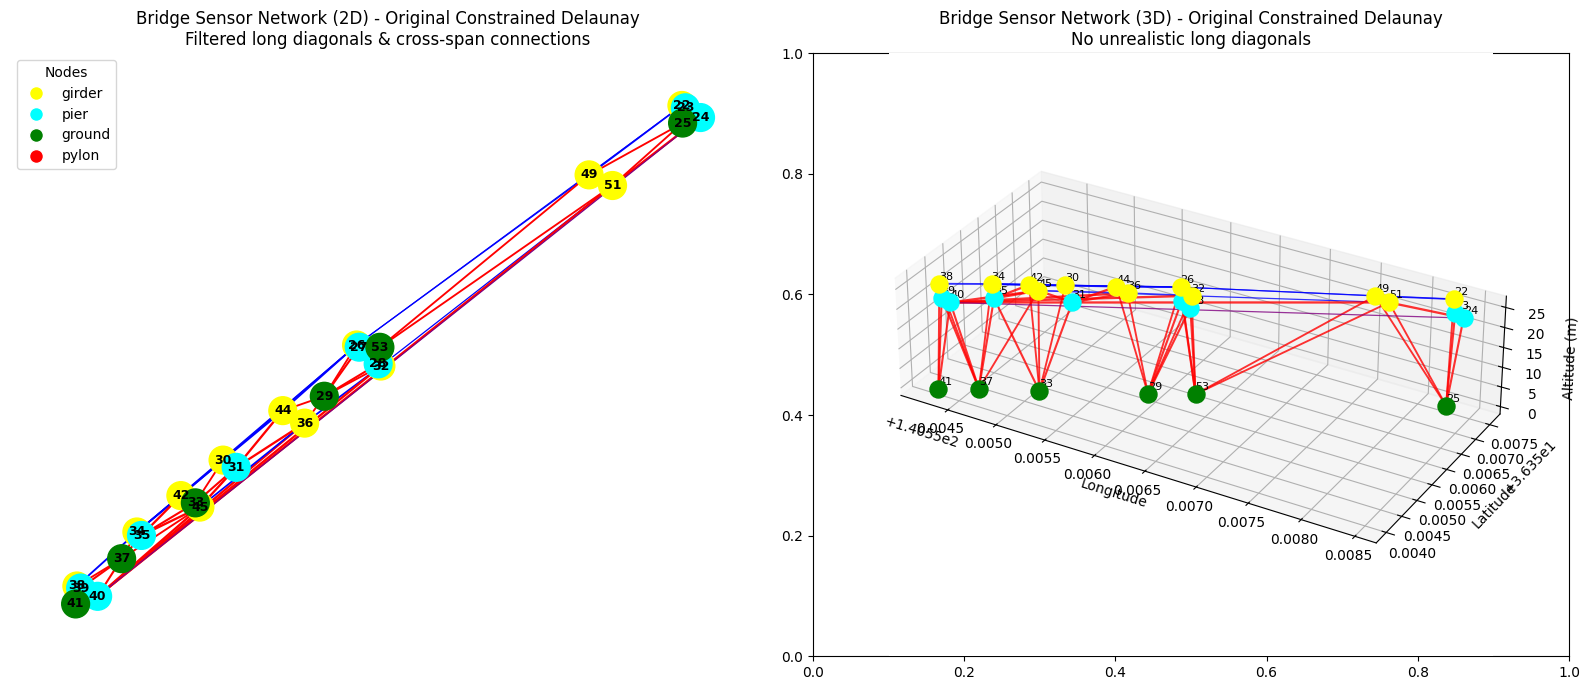


Creating edges with Enhanced Constrained Delaunay

=== Bridge Span Detection (Permissive) ===
Detected 3 bridge spans/sections (eps=60m):
  Span 0: 4 nodes - {'pier': 2, 'girder': 1, 'ground': 1}
  Span 1: 20 nodes - {'girder': 9, 'pier': 6, 'ground': 5}
  Span 2: 2 nodes - {'girder': 2}

Creating Delaunay triangulation for 26 sensors...
Coordinate range: X=-147.4 to 219.9m
Coordinate range: Y=-170.8 to 234.9m
Delaunay triangulation created with 43 triangles
Generated 68 unique edges from triangulation

Applying enhanced structural engineering constraints...

=== Calculating Distance Thresholds (Permissive) ===
  girder-pier: 154.1m (from 10 connections)
  pier-ground: 45.1m (from 7 connections)
  ground-girder: 94.0m (from 9 connections)
  girder-girder: 198.3m (from 16 connections)
  girder-ground: 97.5m (from 9 connections)
  pier-girder: 93.3m (from 7 connections)
  ground-pier: 48.7m (from 6 connections)
  pier-pier: 297.6m (from 4 connections)

=== Filtering Long Diagonal Connec

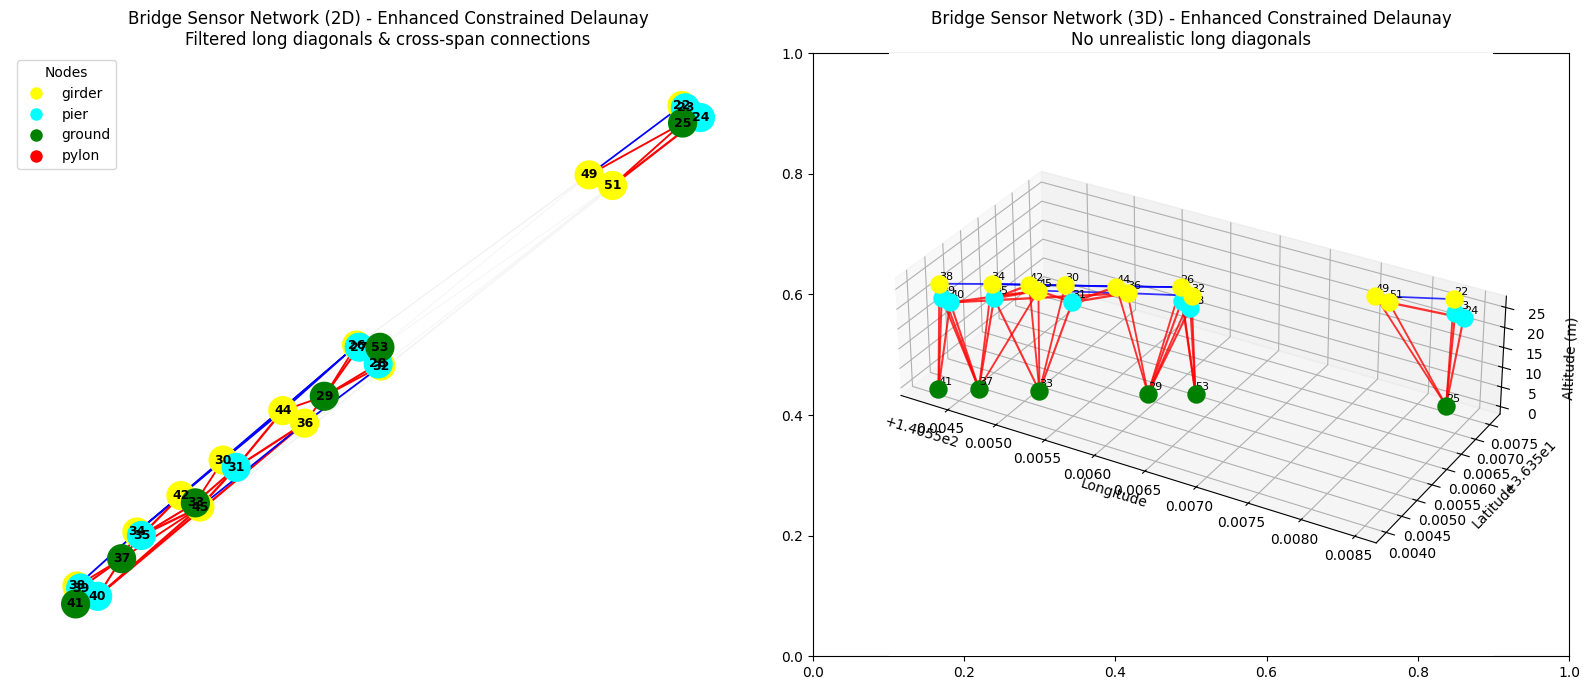


=== Enhanced Delaunay Triangulation Complete ===
Files generated:
  - bridge_edges_original_constrained_delaunay.csv
  - bridge_edges_enhanced_constrained_delaunay.csv

Key Improvements:
  ✓ Intelligent distance thresholds based on connection type
  ✓ Bridge span detection prevents unrealistic cross-gap connections
  ✓ Filtered long diagonal connections that don't represent real structure
  ✓ Maintained structural integrity while removing noise
  ✓ Type-specific filtering (stricter for critical support connections)

Recommendation: Use Enhanced Constrained Delaunay for realistic bridge networks
Benefits:
  - No unrealistic long diagonals across bridge sections
  - Preserves important structural connections (pier-girder, pylon-girder)
  - Better represents actual bridge connectivity
  - Suitable for structural analysis and monitoring


In [32]:
if __name__ == "__main__":
    # Updated CSV data with correct altitude values
    csv_data = """node_id,type,latitude,longitude,altitude_m
22,girder,36.35760246,140.5582758,25.9
26,girder,36.35584565,140.5561452,25.9
30,girder,36.35500155,140.555271,25.9
32,girder,36.35569158,140.5563046,25.9
34,girder,36.35447425,140.5547067,25.9
36,girder,36.35527276,140.5558051,25.9
38,girder,36.35407821,140.5543137,25.9
42,girder,36.35474124,140.5549947,25.9
44,girder,36.35536433,140.5556622,25.9
45,girder,36.3546569,140.5551193,25.9
49,girder,36.35709344,140.5576679,25.9
51,girder,36.35701549,140.5578214,25.9
23,pier,36.35758548,140.5582983,22.7
24,pier,36.35751402,140.5583976,22.7
27,pier,36.35582977,140.5561624,22.7
28,pier,36.35570737,140.5562867,22.7
31,pier,36.35494837,140.5553569,22.7
35,pier,36.35444892,140.5547367,22.7
39,pier,36.35406326,140.5543382,22.7
40,pier,36.35400257,140.5544497,22.7
25,ground,36.3574735,140.5582802,0
29,ground,36.35546989,140.555934,0
33,ground,36.35468793,140.5550896,0
37,ground,36.35427857,140.5546068,0
41,ground,36.35394661,140.5543055,0
53,ground,36.35582872,140.556298,0"""

    # Load data from string
    from io import StringIO
    df = pd.read_csv(StringIO(csv_data))
    
    print("=== Enhanced Shin-Nakagawa Bridge Sensor Network Analysis ===")
    print("New features:")
    print("  ✓ Distance thresholding to avoid long diagonals")
    print("  ✓ Bridge span detection to filter cross-span connections")
    print("  ✓ Intelligent connection type-based thresholds")
    print("  ✓ Enhanced structural constraints")
    print()
    print("Loaded bridge sensor data:")
    print(df.head())
    print(f"\nTotal sensors: {len(df)}")
    print(f"Sensor types: {df['type'].value_counts().to_dict()}")
    
    print("\n=== Custom Stiffness Values ===")
    print("Pier edges: 1.2")
    print("Girder edges: 1.0") 
    print("Pylon edges: 1.5")
    print("Ground edges: 0.8")
    print("Pier-Girder connections: 1.1 (IMPORTANT)")
    print("Pylon-Girder connections: 1.3")
    
    # Compare different approaches
    methods = [
        ("Original Constrained Delaunay", False, False, False),
        ("Enhanced Constrained Delaunay", True, True, True)
    ]
    
    for method_name, enable_constraints, enable_spans, enable_distance in methods:
        print(f"\n{'='*70}")
        print(f"Creating edges with {method_name}")
        print(f"{'='*70}")
        
        if method_name == "Original Constrained Delaunay":
            # Use original method for comparison
            edges, tri = create_delaunay_edges(df, filter_long_edges=False)
            if enable_constraints:
                # Apply basic filtering
                distances_by_type = {}
                for edge in edges:
                    edge_type = edge['type']
                    if edge_type not in distances_by_type:
                        distances_by_type[edge_type] = []
                    distances_by_type[edge_type].append(edge['distance_m'])
                
                max_distances = {}
                for edge_type, distances in distances_by_type.items():
                    distances = np.array(distances)
                    threshold1 = np.mean(distances) + 2 * np.std(distances)
                    threshold2 = np.percentile(distances, 85)
                    max_distances[edge_type] = min(threshold1, threshold2)
                
                filtered_edges = []
                for edge in edges:
                    edge_type = edge['type']
                    distance = edge['distance_m']
                    max_dist = max_distances[edge_type] * (1.2 if edge_type == 'support' else 1.0)
                    
                    if distance <= max_dist:
                        filtered_edges.append(edge)
                
                edges = filtered_edges
        else:
            # Use enhanced method
            edges, tri = create_enhanced_constrained_delaunay_edges(
                df, 
                structural_constraints=enable_constraints,
                enable_span_detection=enable_spans,
                enable_distance_thresholding=enable_distance
            )
        
        # Analyze connections
        analyze_connections(df, edges)
        
        # Save edges
        filename = f'bridge_edges_{method_name.lower().replace(" ", "_").replace("-", "_")}.csv'
        save_edges_csv(edges, filename)
        
        # Create and analyze graph
        G = create_networkx_graph(df, edges)
        analyze_graph_properties(G)
        
        # Visualize
        visualize_delaunay_bridge_network(G, df, tri, method=method_name)
    
    print(f"\n{'='*70}")
    print("=== Enhanced Delaunay Triangulation Complete ===")
    print("Files generated:")
    print("  - bridge_edges_original_constrained_delaunay.csv")
    print("  - bridge_edges_enhanced_constrained_delaunay.csv")
    print("\nKey Improvements:")
    print("  ✓ Intelligent distance thresholds based on connection type")
    print("  ✓ Bridge span detection prevents unrealistic cross-gap connections")
    print("  ✓ Filtered long diagonal connections that don't represent real structure")
    print("  ✓ Maintained structural integrity while removing noise")
    print("  ✓ Type-specific filtering (stricter for critical support connections)")
    print("\nRecommendation: Use Enhanced Constrained Delaunay for realistic bridge networks")
    print("Benefits:")
    print("  - No unrealistic long diagonals across bridge sections")
    print("  - Preserves important structural connections (pier-girder, pylon-girder)")
    print("  - Better represents actual bridge connectivity")
    print("  - Suitable for structural analysis and monitoring")